# **Introduction**

The urban heat island (UHI) effect refers to the phenomenon where urban areas experience higher temperatures compared to their surrounding rural areas due to the built environment, human activities, and lack of vegetation. The intensity of the UHI effect can vary depending on a range of factors, such as local climate, urban density, building materials, and green spaces. While there are cities around the world that are known to experience significant UHI effects, determining the city with the "highest" UHI effect can be complex and may vary depending on the criteria and methodology used for measurement and comparison.

It's important to note that the intensity of the UHI effect can vary within a city depending on local factors such as land use patterns, building density, and the presence of green spaces. Additionally, UHI effects can change over time due to urban planning, mitigation efforts, and climate change impacts. Accurate and comprehensive measurement of UHI effects requires sophisticated monitoring and analysis techniques, including satellite imagery, ground-based measurements, and modeling.



# **Goal**

* Explore urban heat island effect in Quito, Ecuador. 



# **Preliminaries**

The cells below execute the necessary formalities for accessing Earth Engine from this Colab notebook.

In [1]:
# Authenticate

import ee

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

#Authentication to use Google Colab runtimes and download images to Google Drive

from google.colab import drive
drive.mount('/content/drive')

from google.colab import auth
auth.authenticate_user()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=l_LySMc-arqalupwIFJieVVhJUNoWXadeyoNcXt8kJ4&tc=ikVUn_dyENRVjIlzLEr02tnTAGnmVjcHzCoH1tOOyN8&cc=MT4cr8EgqczSiCfmwp7FI6GvQ1-PuMghCu3VxxcS-90

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AVHEtk5od9UDlY5dMO-F5cSUwUUds5XTR6Pasp3y72TknCVH0XYdvEMjhdQ

Successfully saved authorization token.
Mounted at /content/drive


## **Time series analysis**

The analysis uses the Google Earth Engine (GEE) platform using MODIS land cover (LC), the MODIS land surface temperature (LST) and with the USGS ground elevation (ELV) data.

In [9]:
# Import the MODIS land cover collection.
lc = ee.ImageCollection('MODIS/006/MCD12Q1')

# Import the MODIS land surface temperature collection.
lst = ee.ImageCollection('MODIS/006/MOD11A1')

# Import the USGS ground elevation image.
elv = ee.Image('USGS/SRTMGL1_003')

We will filter the collection to for the perios 2017-2020.

In [10]:
# Initial date of interest (inclusive).
i_date = '2017-01-01'

# Final date of interest (exclusive).
f_date = '2020-01-01'

# Selection of appropriate bands and dates for LST.
lst = lst.select('LST_Day_1km', 'QC_Day').filterDate(i_date, f_date)

Now we will select the points of interest ("poi"). The first point will be in the center of Quito, and the second 27,59 Km south in a rural area (Tambillo). 

In [11]:
# Define the urban location of interest as a point near Quito, Ecuador.
u_lon = -78.487778
u_lat = -0.1641667
u_poi = ee.Geometry.Point(u_lon, u_lat)

# Define the rural location of interest as a point away from the city (Tambillo).
r_lon = -78.541944
r_lat = -0.4147222
r_poi = ee.Geometry.Point(r_lon, r_lat)

We will query the ground elevation and LST around our point of interest.

In [12]:
scale = 1000  # scale in meters

# Print the elevation in Quito, Ecuador.
elv_urban_point = elv.sample(u_poi, scale).first().get('elevation').getInfo()
print('Ground elevation at urban point:', elv_urban_point, 'm')

# Calculate and print the mean value of the LST collection at the point.
lst_urban_point = lst.mean().sample(u_poi, scale).first().get('LST_Day_1km').getInfo()
print('Average daytime LST at urban point:', round(lst_urban_point*0.02 -273.15, 2), '°C')

# Print the land cover type at the point.
lc_urban_point = lc.first().sample(u_poi, scale).first().get('LC_Type1').getInfo()
print('Land cover value at urban point is:', lc_urban_point)

Ground elevation at urban point: 2788 m
Average daytime LST at urban point: 27.95 °C
Land cover value at urban point is: 13


In [41]:
scale = 1000  # scale in meters

# Print the elevation in Tambillo, Ecuador.
elv_rural_point = elv.sample(r_poi, scale).first().get('elevation').getInfo()
print('Ground elevation at rural point:', elv_rural_point, 'm')

# Calculate and print the mean value of the LST collection at the point.
lst_rural_point = lst.mean().sample(r_poi, scale).first().get('LST_Day_1km').getInfo()
print('Average daytime LST at rural point:', round(lst_rural_point*0.02 -273.15, 2), '°C')

# Print the land cover type at the point.
lc_rural_point = lc.first().sample(r_poi, scale).first().get('LC_Type1').getInfo()
print('Land cover value at rural point is:', lc_rural_point)

Ground elevation at rural point: 2717 m
Average daytime LST at rural point: 22.95 °C
Land cover value at rural point is: 13


we import the data at the given locations using the getRegion() method.

In [13]:
# Get the data for the pixel intersecting the point in urban area.
lst_u_poi = lst.getRegion(u_poi, scale).getInfo()

# Get the data for the pixel intersecting the point in rural area.
lst_r_poi = lst.getRegion(r_poi, scale).getInfo()

# Preview the result.
lst_u_poi[:5]

[['id', 'longitude', 'latitude', 'time', 'LST_Day_1km', 'QC_Day'],
 ['2017_01_01',
  -78.4902979499432,
  -0.1661883275621115,
  1483228800000,
  15090,
  145],
 ['2017_01_02',
  -78.4902979499432,
  -0.1661883275621115,
  1483315200000,
  None,
  2],
 ['2017_01_03',
  -78.4902979499432,
  -0.1661883275621115,
  1483401600000,
  14685,
  145],
 ['2017_01_04',
  -78.4902979499432,
  -0.1661883275621115,
  1483488000000,
  15115,
  145]]

We now define a function to transform this array into a pandas Dataframe which is much more convenient to manipulate.

In [14]:
import pandas as pd

def ee_array_to_df(arr, list_of_bands):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Remove rows without data inside.
    df = df[['longitude', 'latitude', 'time', *list_of_bands]].dropna()

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')

    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')

    # Keep the columns of interest.
    df = df[['time','datetime',  *list_of_bands]]

    return df

We apply this function to get the two time series we want (and print one).

In [15]:
lst_df_urban = ee_array_to_df(lst_u_poi,['LST_Day_1km'])

def t_modis_to_celsius(t_modis):
    """Converts MODIS LST units to degrees Celsius."""
    t_celsius =  0.02*t_modis - 273.15
    return t_celsius

# Apply the function to get temperature in celsius.
lst_df_urban['LST_Day_1km'] = lst_df_urban['LST_Day_1km'].apply(t_modis_to_celsius)

# Do the same for the rural point.
lst_df_rural = ee_array_to_df(lst_r_poi,['LST_Day_1km'])
lst_df_rural['LST_Day_1km'] = lst_df_rural['LST_Day_1km'].apply(t_modis_to_celsius)

lst_df_urban.head()

,time,datetime,LST_Day_1km
0,1483228800000,2017-01-01,28.65
2,1483401600000,2017-01-03,20.55
3,1483488000000,2017-01-04,29.15
7,1483833600000,2017-01-08,31.81
11,1484179200000,2017-01-12,22.77


Now that we have our data in a good shape, we can easily make plots and compare the trends.

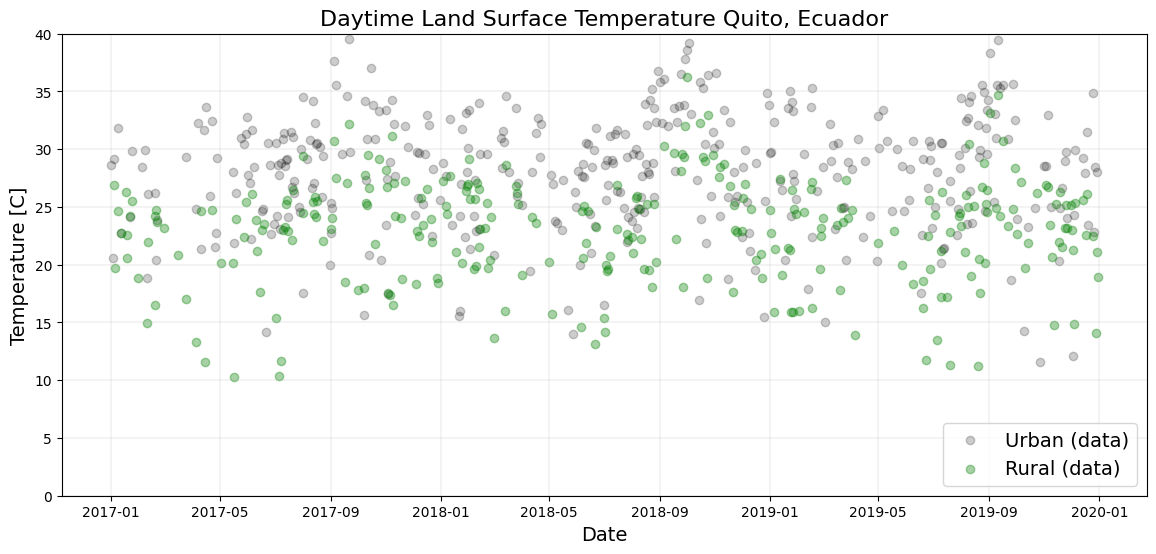

In [37]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
%matplotlib inline

# Fitting curves.
## First, extract x values (times) from the dfs.
x_data_u = np.asanyarray(lst_df_urban['time'].apply(float))  # urban
x_data_r = np.asanyarray(lst_df_rural['time'].apply(float))  # rural

## Secondly, extract y values (LST) from the dfs.
y_data_u = np.asanyarray(lst_df_urban['LST_Day_1km'].apply(float))  # urban
y_data_r = np.asanyarray(lst_df_rural['LST_Day_1km'].apply(float))  # rural


# Subplots.
fig, ax = plt.subplots(figsize=(14, 6))

# Add scatter plots.
ax.scatter(lst_df_urban['datetime'], lst_df_urban['LST_Day_1km'],
           c='black', alpha=0.2, label='Urban (data)')
ax.scatter(lst_df_rural['datetime'], lst_df_rural['LST_Day_1km'],
           c='green', alpha=0.35, label='Rural (data)')

# Add some parameters.
ax.set_title('Daytime Land Surface Temperature Quito, Ecuador', fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Temperature [C]', fontsize=14)
ax.set_ylim(-0, 40)
ax.grid(lw=0.2)
ax.legend(fontsize=14, loc='lower right')

LST_quito = plt.savefig('LST_quito.png')
plt.show()

We can clearly see how the urban land temperature is higher than the rural one.

# Static mapping of land surface temperature and ground elevation

We define this region of interest using a buffer zone of 500 km around Quito, Ecuador.




In [20]:
# Define a region of interest with a buffer zone of 500 km around Lyon.
roi = u_poi.buffer(5e5)

Also, we have to convert the LST ee.ImageCollection into an ee.Image, for example by taking the mean value of each pixel over the period of interest. And we convert the value of pixels into Celsius:

In [21]:
# Reduce the LST collection by mean.
lst_img = lst.mean()

# Adjust for scale factor.
lst_img = lst_img.select('LST_Day_1km').multiply(0.02)

# Convert Kelvin to Celsius.
lst_img = lst_img.select('LST_Day_1km').add(-273.15)

Then, we use the getThumbUrl() method to get a URL and we can use the IPython library to display the mean daytime LST map for the region of interest. Blue represents the coldest areas (< 10°C) and red represents the warmest areas (> 30°C)

In [23]:
from IPython.display import Image

# Create a URL to the styled image for a region around Ecuador.
url = lst_img.getThumbUrl({
    'min': 10, 'max': 30, 'dimensions': 512, 'region': roi,
    'palette': ['blue', 'yellow', 'orange', 'red']})
print(url)

# Display the thumbnail land surface temperature in Ecuador.
print('\nPlease wait while the thumbnail loads, it may take a moment...')
Image(url=url)

https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/14e3f3b68092c9f7b7583758a51c8671-55ed7f8229f4ab8e74784289a7fe8b3c:getPixels

Please wait while the thumbnail loads, it may take a moment...


We do the same for ground elevation:

In [24]:
# Make pixels with elevation below sea level transparent.
elv_img = elv.updateMask(elv.gt(0))

# Display the thumbnail of styled elevation in Ecuador.
Image(url=elv_img.getThumbURL({
    'min': 0, 'max': 4000, 'dimensions': 512, 'region': roi,
    'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']}))

Let's define another region (a buffer zone around Quito).

In [26]:
# Create a buffer zone of 10 km around Quito.
quito = u_poi.buffer(10000)  # meters

url = elv_img.getThumbUrl({
    'min': 2000, 'max': 4000, 'region': quito, 'dimensions': 512,
    'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']})
Image(url=url)

Now we will clip the image of Ecuador

In [28]:
# Get a feature collection of administrative boundaries.
countries = ee.FeatureCollection('FAO/GAUL/2015/level0').select('ADM0_NAME')

# Filter the feature collection to subset Ecuador.
ecuador = countries.filter(ee.Filter.eq('ADM0_NAME', 'Ecuador'))

# Clip the image by Ecuador.
elv_ec = elv_img.clip(ecuador)

# Create the URL associated with the styled image data.
url = elv_ec.getThumbUrl({
    'min': 0, 'max': 4000, 'region': roi, 'dimensions': 512,
    'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']})

# Display a thumbnail of elevation in Ecuador.
Image(url=url)

# Save the GeoTIFF file to Google Drive

In [29]:
task = ee.batch.Export.image.toDrive(image=elv_img,
                                     description='elevation_quito',
                                     scale=30,
                                     region=quito,
                                     fileNamePrefix='my_export_quito',
                                     crs='EPSG:4326',
                                     fileFormat='GeoTIFF')
task.start()

# Interactive mapping using folium

In [30]:
import folium

# Define the center of our map.
lat, lon = -0.1641667, -78.487778

my_map = folium.Map(location=[lat, lon], zoom_start=10)
my_map

On top of this map, we now want to add the GEE layers we studied before: land cover (LC), land surface temperature (LST) and ground elevation model (ELV). For each GEE dataset, the process consists of adding a new tile layer to our map with specified visualization parameters. Let's define a new method for handing Earth Engine tiles and using it to display an elevation model to a Leaflet map.

In [31]:
def add_ee_layer(self, ee_image_object, vis_params, name):
    """Adds a method for displaying Earth Engine image tiles to folium map."""
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name=name,
        overlay=True,
        control=True
    ).add_to(self)

# Add Earth Engine drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

We want to respect the common LC classes defined in the table of the previous section (hexadecimal codes are given for each class: water bodies are blue, urban areas are grey, forests are green, etc.). Then we define visualization parameters associated with LC and apply the method we defined earlier:

In [32]:
# Select a specific band and dates for land cover.
lc_img = lc.select('LC_Type1').filterDate(i_date).first()

# Set visualization parameters for land cover.
lc_vis_params = {
    'min': 1,'max': 17,
    'palette': ['05450a','086a10', '54a708', '78d203', '009900', 'c6b044',
                'dcd159', 'dade48', 'fbff13', 'b6ff05', '27ff87', 'c24f44',
                'a5a5a5', 'ff6d4c', '69fff8', 'f9ffa4', '1c0dff']
}

# Create a map.
lat, lon = -0.1641667, -78.487778
my_map = folium.Map(location=[lat, lon], zoom_start=7)

# Add the land cover to the map object.
my_map.add_ee_layer(lc_img, lc_vis_params, 'Land Cover')

# Add a layer control panel to the map.
my_map.add_child(folium.LayerControl())

# Display the map.
display(my_map)

Finally, the map can be saved in HTML format using the folium method save() specifying the file name as an argument of this method.

In [33]:
my_map.save('my_lc_interactive_map.html')

Of course we can add other datasets similarly, by defining some visualization parameters and by adding the appropriate tiles:

In [34]:
# Set visualization parameters for ground elevation.
elv_vis_params = {
    'min': 0, 'max': 4000,
    'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']}

# Set visualization parameters for land surface temperature.
lst_vis_params = {
    'min': 0, 'max': 40,
    'palette': ['white', 'blue', 'green', 'yellow', 'orange', 'red']}

# Arrange layers inside a list (elevation, LST and land cover).
ee_tiles = [elv_img, lst_img, lc_img]

# Arrange visualization parameters inside a list.
ee_vis_params = [elv_vis_params, lst_vis_params, lc_vis_params]

# Arrange layer names inside a list.
ee_tiles_names = ['Elevation', 'Land Surface Temperature', 'Land Cover']

# Create a new map.
lat, lon = -0.1641667, -78.487778
my_map = folium.Map(location=[lat, lon], zoom_start=5)

# Add layers to the map using a loop.
for tile, vis_param, name in zip(ee_tiles, ee_vis_params, ee_tiles_names):
    my_map.add_ee_layer(tile, vis_param, name)

folium.LayerControl(collapsed = False).add_to(my_map)

my_map

**Conclusions**



1.   There is a mean land surface temperature difference between Quito and Tambillo of 5 degrees (period 2017-2020). 
2.   The urban heat island effect is responsible for this temperature difference since the altitude difference between these two areas is only 71 m.
3. Even though, Tambillo's land cover type is catalogued in the data set as "urban", from field recognition it is known that Tambillo is mostly a rural area.  

